# This notebook compares the loss, label transfer accuracy and label transfer ARI between some integration methods. Such as Direct alignment, Manual grossalignment, Manual grossalignment+further alignment, ICP alignment, FGW alignment, ICP+FGW alignment.

# import module

In [1]:
from hacca import hacca
import scanpy as sc
from hacca.data import Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# set working directory

In [44]:
#### dir name
cwd="I:\\mutiomics\\"
data_path = os.path.join(cwd, 'data')
work_dir = os.path.join(cwd, 'work_test')
if not os.path.exists(work_dir):
    os.makedirs(work_dir)

# <font size=2>**Read in data** 
# <font size=1>We align b_prime to a in this case, a is pseudo-MSI-MALDI and b_prime is 10X Visum.

In [28]:
a_h5ad = sc.read_h5ad(os.path.join(data_path, "M2.h5ad"))
b_prime_h5ad = sc.read_h5ad(os.path.join(data_path,"M1.h5ad"))

# <font size=2>**Data preprocession.**

In [29]:
a_h5ad.obs["leiden"] = a_h5ad.obs["clusters"]
b_prime_h5ad.obs["leiden"] = b_prime_h5ad.obs["clusters"]

# <font size=1>lets take a look at a and b_prime

a AnnData object with n_obs × n_vars = 1000 × 2499
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'
b_prime AnnData object with n_obs × n_vars = 1000 × 2500
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total

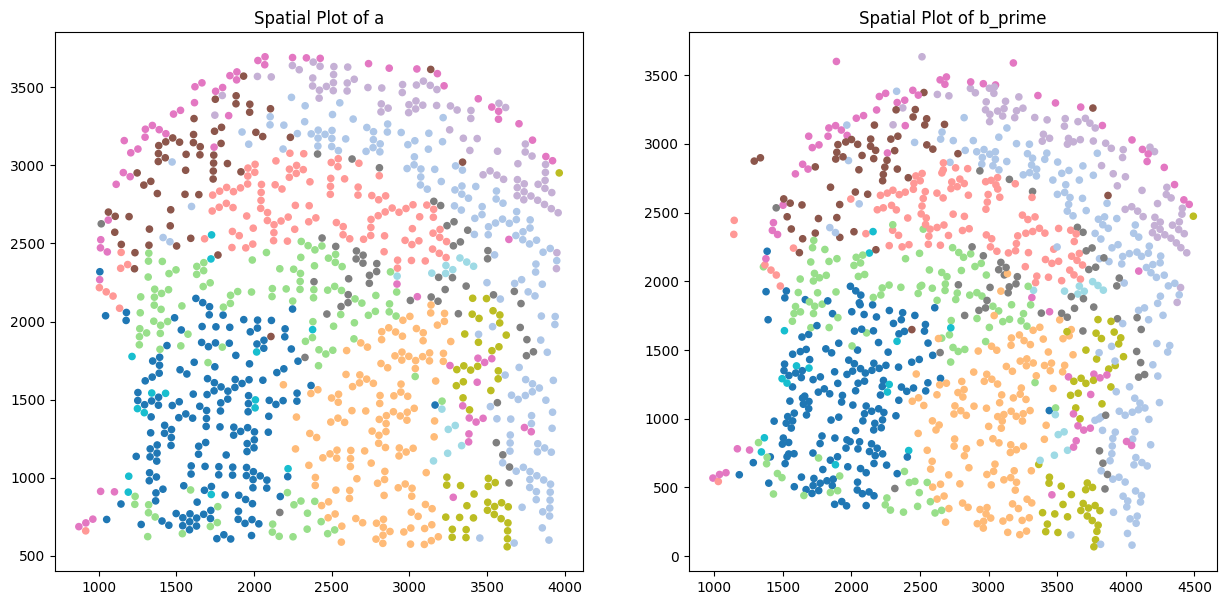

In [42]:
print("a",a_h5ad)
print("b_prime",b_prime_h5ad)
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].scatter(a_h5ad.obsm["spatial"][:,0], a_h5ad.obsm["spatial"][:,1], c=a_h5ad.obs['leiden'].astype(int), cmap='tab20', s=20, alpha=1,)
axs[0].set_title('Spatial Plot of a')
axs[1].scatter(b_prime_h5ad.obsm["spatial"][:,0], b_prime_h5ad.obsm["spatial"][:,1], c=b_prime_h5ad.obs['leiden'].astype(int), cmap='tab20', s=20, alpha=1)
axs[1].set_title('Spatial Plot of b_prime')
plt.show()

# <font size=1>scale spatial data of a and b_prime,defalut[0-500]

In [43]:
b_prime_spatial = pd.DataFrame(b_prime_h5ad.obsm['spatial'])
scaledata = hacca.center_and_scale(b_prime_spatial)
b_prime_spatial = pd.DataFrame(scaledata, columns=b_prime_spatial.columns).to_numpy()
a_spatial = pd.DataFrame(a_h5ad.obsm['spatial'])
scaledata = hacca.center_and_scale(a_spatial)
a_spatial = pd.DataFrame(scaledata, columns=a_spatial.columns).to_numpy()

# <font size=1> turn a and b_prime into hacca.Data format: Data(X(n,m),D(n,2),Lable(n,1)). n is the number of spots and m is the number of features. 

In [49]:
a = Data(X=a_h5ad.X.toarray(), D = a_spatial, Label=a_h5ad.obs['leiden'].to_numpy())
b_prime = Data(X=b_prime_h5ad.X.toarray(), D = b_prime_spatial, Label=b_prime_h5ad.obs['leiden'].to_numpy())
b_truth = a

# <font size=2>**Then lets compares a few alignment method,start with hacca**

# <font size=2>**haCCA** 
# <font size=1>the outcome of haCCA is preserved in folder haCCA

I:\mutiomics\pythonProject\.venv\lib\site-packages\hacca\hacca.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_C_.loc[:,'BprimeID'] = values
I:\mutiomics\pythonProject\.venv\lib\site-packages\hacca\hacca.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_.loc[:,'AID'] = values
I:\mutiomics\pythonProject\.venv\lib\site-packages\hacca\hacca.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


haCCA: loss: (123.69532, 0.972, 0.9425969504915974)


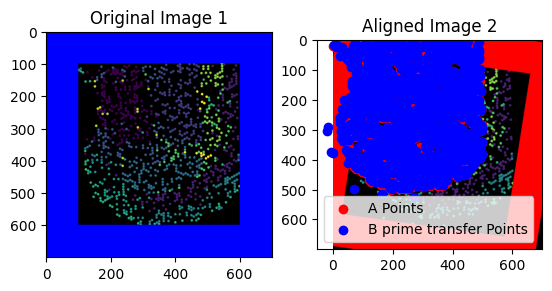

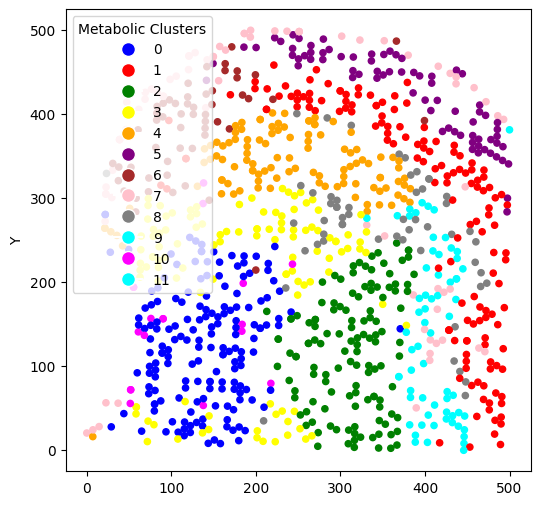

In [50]:
haCCA_work_dir = os.path.join(work_dir, 'haCCA')
if not os.path.exists(haCCA_work_dir):
    os.makedirs(haCCA_work_dir)
_b_prime = hacca.manual_gross_alignment(a, b_prime, work_dir=haCCA_work_dir)
_b_prime = hacca.further_alignment(a, _b_prime)
_a, _b_prime = hacca.icp_3d_alignment(a, _b_prime)
b_preidct = hacca.direct_alignment(_a, _b_prime, work_dir=haCCA_work_dir)
haCCA = hacca.loss(b_preidct, b_truth)
print(f"haCCA: loss: {haCCA}")
hacca.plot_b_predict(b_preidct,haCCA_work_dir)

# <font size=2>**ICP 3D alignment** 
# <font size=1>the outcome of haCCA is preserved in folder icp_3d

I:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
I:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ICP 3D: loss: (451.30368, 0.615, 0.4452777203140779)


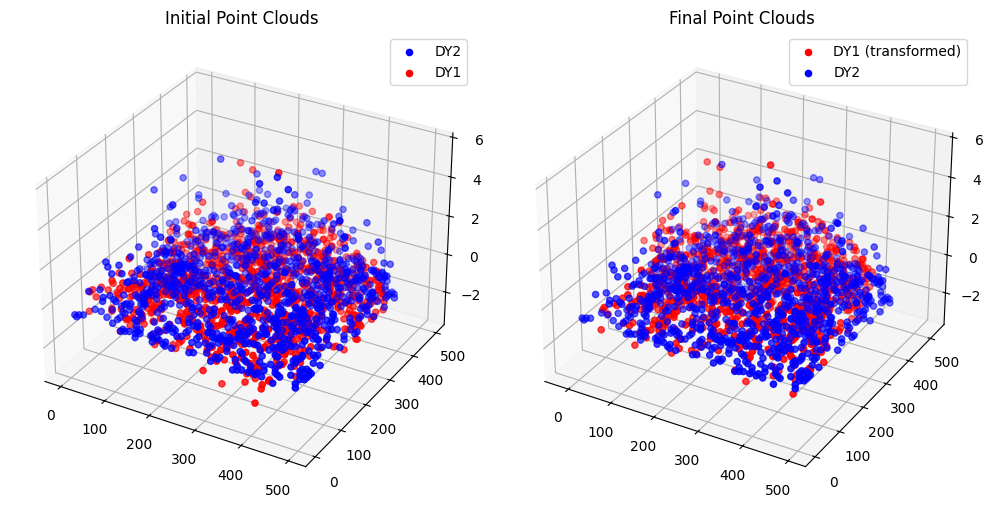

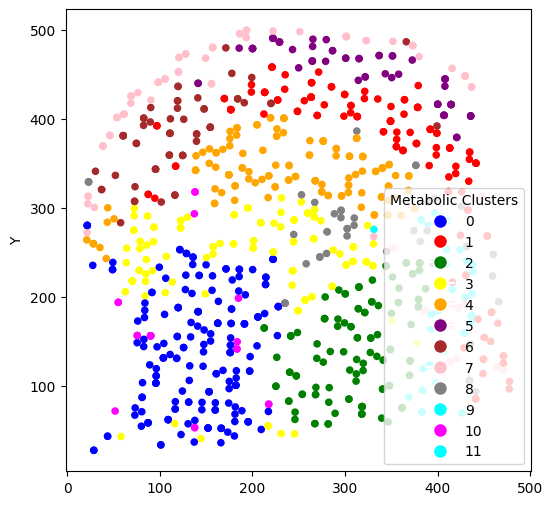

In [52]:
icp_3d_work_dir = os.path.join(work_dir, 'icp_3d')
if not os.path.exists(icp_3d_work_dir):
    os.makedirs(icp_3d_work_dir)
_a, _b_prime = hacca.icp_3d_alignment(a, b_prime, icp_3d_work_dir)
b_predict = hacca.direct_alignment(_a, _b_prime, work_dir=icp_3d_work_dir)
hacca.plot_b_predict(b_predict, icp_3d_work_dir)
icp_3d_loss = hacca.loss(b_predict, b_truth)
print(f"ICP 3D: loss: {icp_3d_loss}")

# <font size=2>**FGW 3D alignment** 
# <font size=1>the outcome of haCCA is preserved in folder fgw_3d

I:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
I:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FGW 3D: loss: (515.4535, 0.195, 0.14366993657454144)


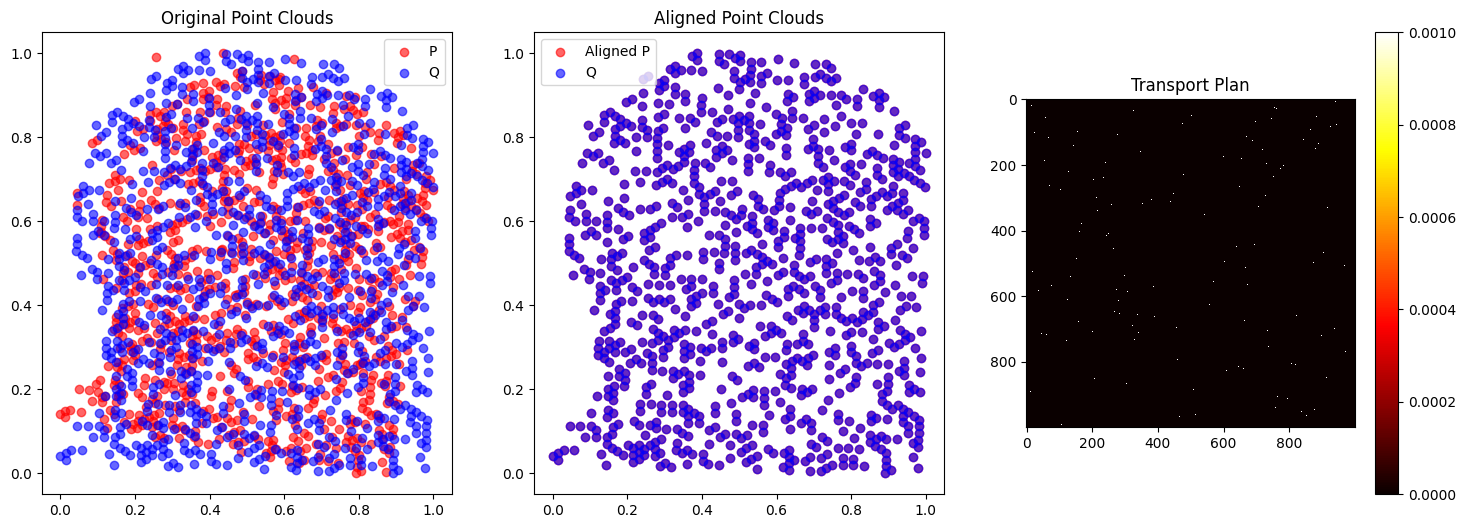

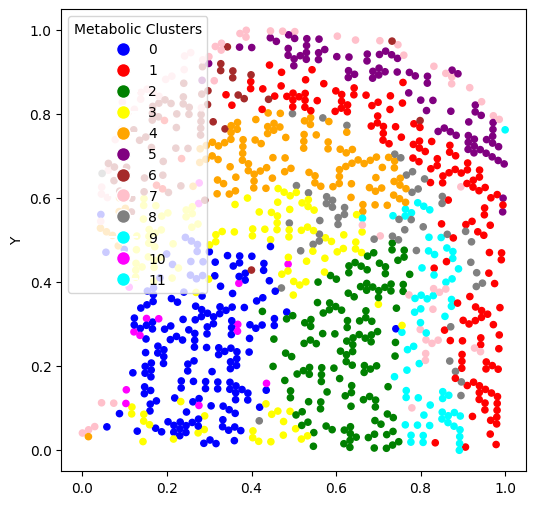

In [53]:
fgw_3d_work_dir = os.path.join(work_dir, 'fgw_3d')
if not os.path.exists(fgw_3d_work_dir):
        os.makedirs(fgw_3d_work_dir)
_a, _b_prime = hacca.fgw_3d_alignment(a, b_prime, fgw_3d_work_dir, alpha=0.8)
b_predict = hacca.direct_alignment(_a, _b_prime, work_dir=fgw_3d_work_dir)
hacca.plot_b_predict(b_predict, fgw_3d_work_dir)
fgw_3d_loss = hacca.loss(b_predict, b_truth)
print(f"FGW 3D: loss: {fgw_3d_loss}")

# <font size=2>**FGW 2D alignment** 
# <font size=1>the outcome of haCCA is preserved in folder fgw_2d

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FGW 2D: loss: (444.08023, 0.643, 0.445767601842681)


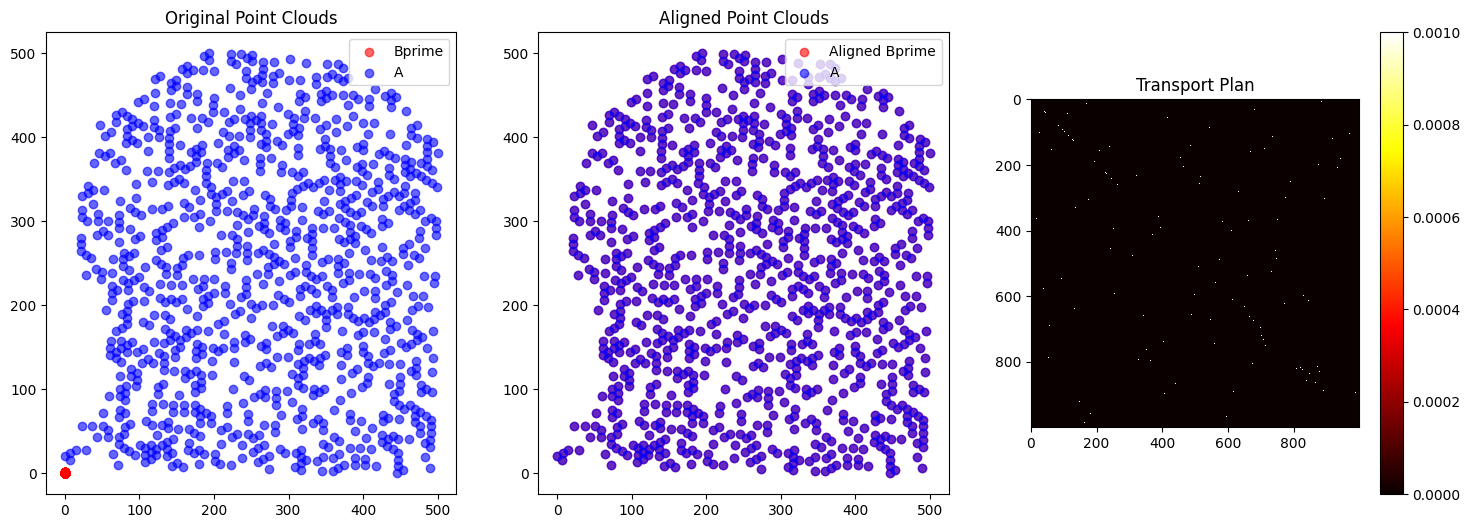

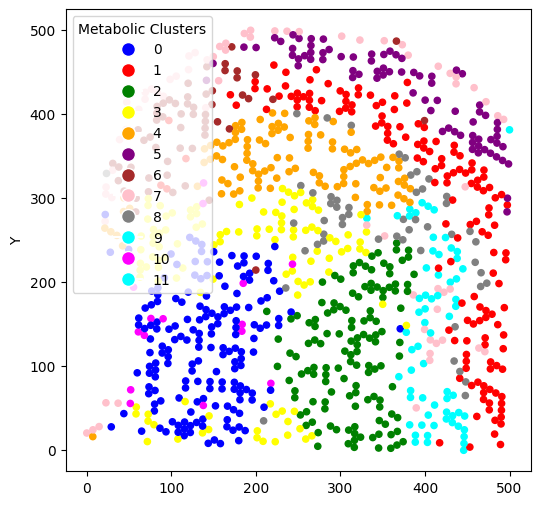

In [54]:
fgw_2d_work_dir = os.path.join(work_dir, 'fgw_2d')
if not os.path.exists(fgw_2d_work_dir):
        os.makedirs(fgw_2d_work_dir)
_b_prime = hacca.fgw_2d_alignment(a, b_prime, fgw_2d_work_dir)
b_predict = hacca.direct_alignment(a, _b_prime, work_dir=fgw_2d_work_dir)
hacca.plot_b_predict(b_predict, fgw_2d_work_dir)
fgw_2d_loss = hacca.loss(b_predict, b_truth)
print(f"FGW 2D: loss: {fgw_2d_loss}")

# <font size=2>**ICP 2D alignment** 
# <font size=1>the outcome of haCCA is preserved in folder icp_2d|

Converged after 43 iterations.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ICP 2D: loss: (451.50043, 0.56, 0.42609361293806763)


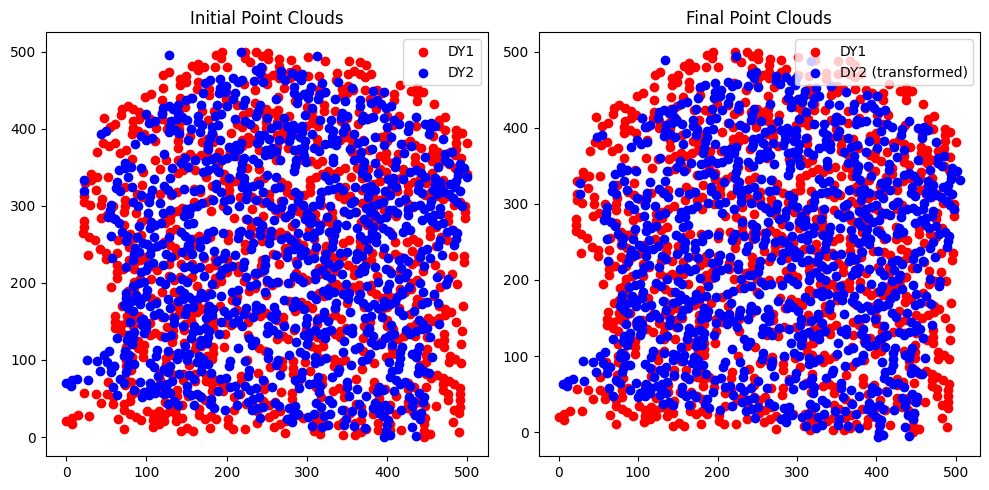

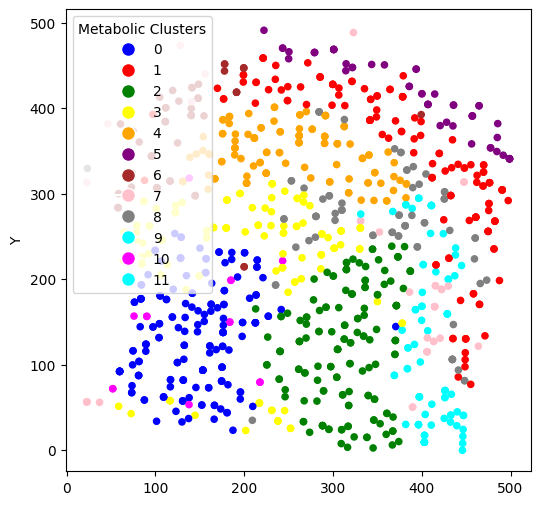

In [55]:
icp_2d_work_dir = os.path.join(work_dir, 'icp_2d')
if not os.path.exists(icp_2d_work_dir):
    os.makedirs(icp_2d_work_dir)

_b_prime = hacca.icp_2d_alignment(a, b_prime, icp_2d_work_dir)
b_predict = hacca.direct_alignment(a, _b_prime, work_dir=icp_2d_work_dir)
hacca.plot_b_predict(b_predict, icp_2d_work_dir)
icp_2d_loss = hacca.loss(b_predict, b_truth)
print(f"ICP 2D: loss: {icp_2d_loss}")

# <font size=2>**direct alignment** 
# <font size=1>the outcome of haCCA is preserved in folder direct_alignment

direct_alignment_work_dir = os.path.join(work_dir, 'direct_alignment')
if not os.path.exists(direct_alignment_work_dir):
    os.makedirs(direct_alignment_work_dir)
    
b_predict = hacca.direct_alignment(a, b_prime, direct_alignment_work_dir)
hacca.plot_b_predict(b_predict, direct_alignment_work_dir)
direct_alignment_loss = hacca.loss(b_predict, b_truth)
print(f"Direct alignment w/ center and scale: loss: {direct_alignment_loss}")

# <font size=2>**manual alignment** 
# <font size=1>the outcome of haCCA is preserved in folder manual alignment
# <font size=1>Well, how to say, this is the mostly used way, to align 10X Visium and MALDI

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


manual_alignment: loss: (392.19318, 0.647, 0.4754550376142222)


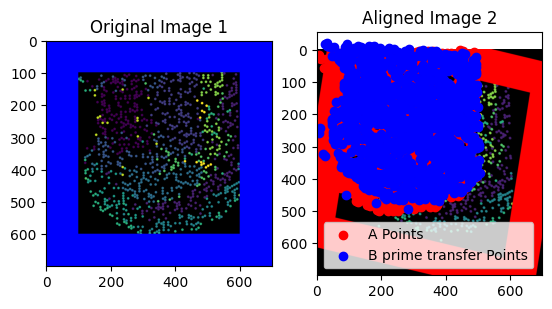

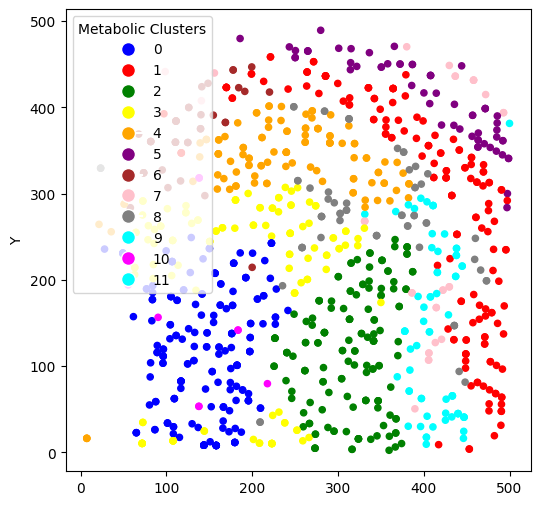

In [58]:
manual_alignment_work_dir = os.path.join(work_dir, 'manual alignment')
if not os.path.exists(manual_alignment_work_dir):
    os.makedirs(manual_alignment_work_dir)
_b_prime = hacca.manual_gross_alignment(a, b_prime, work_dir=manual_alignment_work_dir)
b_preidct = hacca.direct_alignment(a, _b_prime, work_dir=manual_alignment_work_dir)
manual_alignment = hacca.loss(b_preidct, b_truth)
print(f"manual_alignment: loss: {manual_alignment}")
hacca.plot_b_predict(b_preidct,manual_alignment_work_dir)

# <font size=2>**ICD2D-FGW3D alignment** 
# <font size=1>the outcome of haCCA is preserved in folder ICD2D_FGW3D

I:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
I:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Run FWG2D-ICP3D alignment: loss: (445.05667, 0.644, 0.44684815421662444)


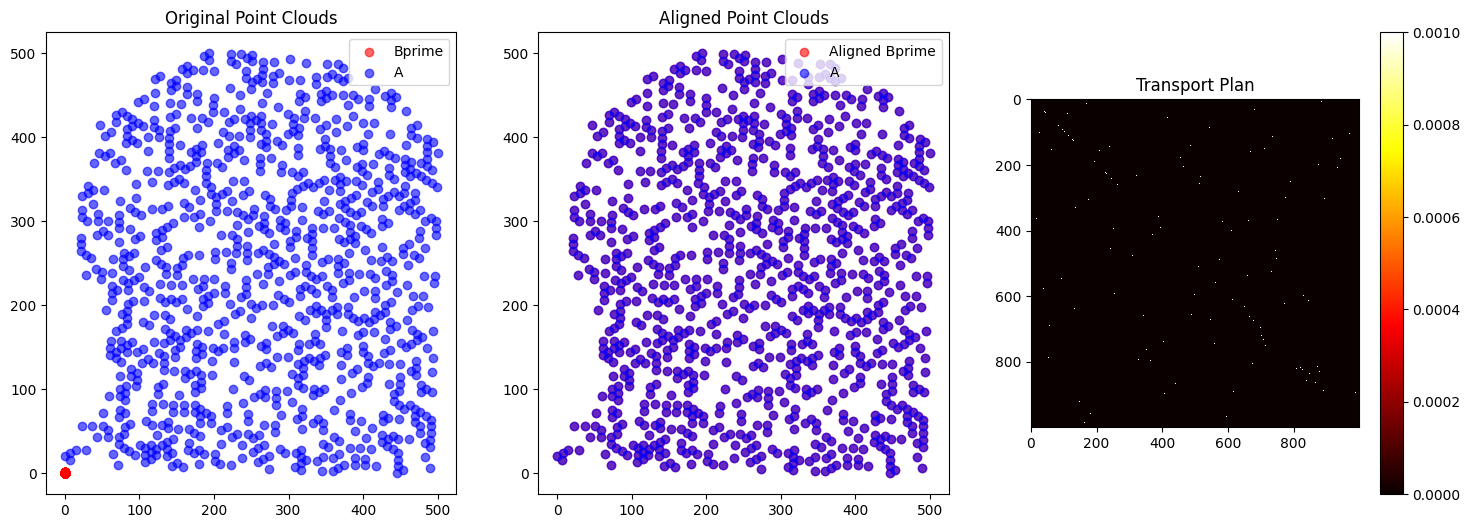

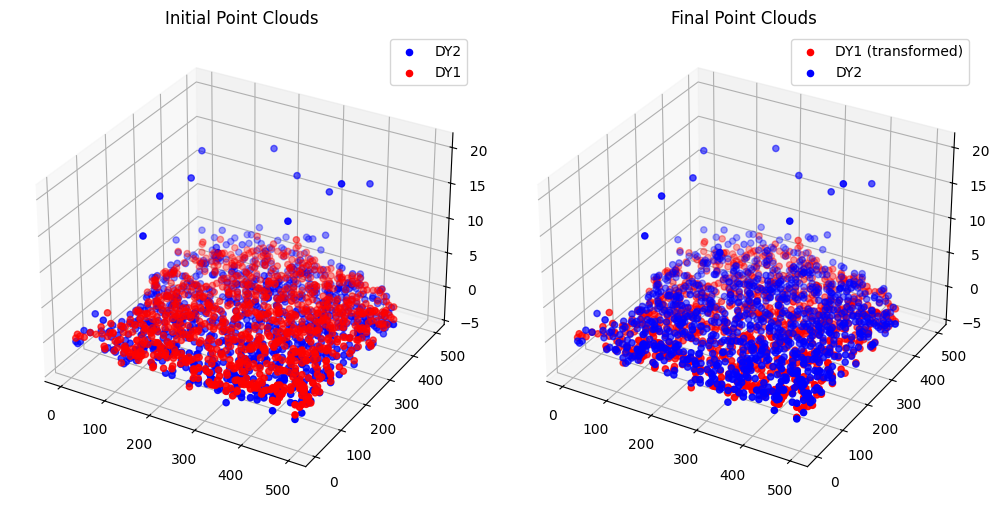

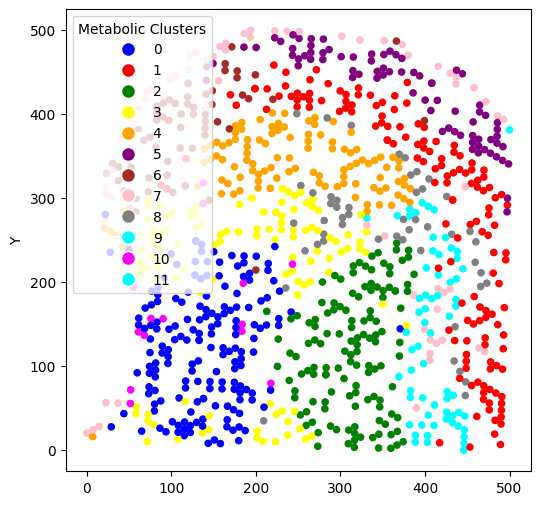

In [60]:
ICD2D_FGW3D_alignment_work_dir = os.path.join(work_dir, 'ICD2D_FGW3D')
if not os.path.exists(ICD2D_FGW3D_alignment_work_dir):
    os.makedirs(ICD2D_FGW3D_alignment_work_dir)
    
_b_prime = hacca.fgw_2d_alignment(a, b_prime, ICD2D_FGW3D_alignment_work_dir)
_a, _b_prime = hacca.icp_3d_alignment(a, _b_prime, ICD2D_FGW3D_alignment_work_dir)
b_predict = hacca.direct_alignment(_a, _b_prime, ICD2D_FGW3D_alignment_work_dir)
hacca.plot_b_predict(b_predict, ICD2D_FGW3D_alignment_work_dir)
ICD2D_FGW3D_alignment_loss = hacca.loss(b_predict, b_truth)
print(f"Run FWG2D-ICP3D alignment: loss: {ICD2D_FGW3D_alignment_loss}")

# <font size=2>**Lets compare the performance** 
# <font size=2>Format: [loss, label transfer accuracy, label transfer ARI]

In [63]:
print(f"haCCA: loss: {haCCA}")
print(f"FWG2D-ICP3D alignment: loss: {ICD2D_FGW3D_alignment_loss}")
print(f"manual_alignment: loss: {manual_alignment}")
print(f"Direct alignment: loss: {direct_alignment_loss}")
print(f"ICP 2D: loss: {icp_2d_loss}")
print(f"FGW 2D: loss: {fgw_2d_loss}")
print(f"FGW 3D: loss: {fgw_3d_loss}")
print(f"ICP 3D: loss: {icp_3d_loss}")

haCCA: loss: (123.69532, 0.972, 0.9425969504915974)
FWG2D-ICP3D alignment: loss: (445.05667, 0.644, 0.44684815421662444)
manual_alignment: loss: (392.19318, 0.647, 0.4754550376142222)
Direct alignment: loss: (482.68866, 0.585, 0.4424561849827252)
ICP 2D: loss: (451.50043, 0.56, 0.42609361293806763)
FGW 2D: loss: (444.08023, 0.643, 0.445767601842681)
FGW 3D: loss: (515.4535, 0.195, 0.14366993657454144)
ICP 3D: loss: (451.30368, 0.615, 0.4452777203140779)
